# Extracting spatial data for Great Barrier Reef features
**Author**: Denisse Fierro Arcos  
  
This notebook will show how to access the RIMReP `geoparquet` collection for Great Barrier Reef (GBR) Feature from the Great Barrier Reef Marine Park Authority (GBRMPA). This dataset includes the unique IDs and names of all features above water, including sand banks, reefs, cays, islets, and islands. Since this dataset includes spatial data, we can extract the spatial limits of each feature included in this dataset.  
  
We will use the spatial boundaries to extract environmental or biological information for sites of our interest.  
  
## Worfklow to be followed in this notebook
1. Connect to RIMReP_DMS and inspect metadata
2. Load GBR features from data collection  
3. Get GBR features geometries to extract information from biological or environmental dataset within an area of interest
4. Export polygons as shapefiles

## Loading libraries

In [1]:
# Accessing S3 bucket
from pyarrow import parquet as pq
# Load and manipulate geospatial data
import dask_geopandas
import geopandas as gpd
# Plotting
import matplotlib.pyplot as plt
# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cf
# Dealing with operating system, i.e. reading and writing files
import os

## Inspecting metadata
To get a better understanding of the GBR features dataset, we will inspect its metadata. This information will also help us determine the best way to load the data into memory.

In [4]:
#Connecting to metadata file
md = pq.read_metadata(f's3://rimrep-data-public/gbrmpa-complete-gbr-features/data.parquet')
#Checking contents
md

  created_by: parquet-cpp-arrow version 11.0.0
  num_columns: 41
  num_rows: 9612
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 22344

The metadata is telling us that this dataset contains 41 columns and 9,612 rows. Each row represents a unique feature in the GBR.
  
We can check the structure of the data by calling its `schema` attribute. This will return a list containing the name of the column and its data type.

In [5]:
md.schema

required group field_id=-1 schema {
  optional int64 field_id=-1 TARGET_FID;
  optional binary field_id=-1 DATASET (String);
  optional binary field_id=-1 LOC_NAME_S (String);
  optional binary field_id=-1 GBR_NAME (String);
  optional binary field_id=-1 CHART_NAME (String);
  optional binary field_id=-1 TRAD_NAME (String);
  optional binary field_id=-1 UN_FEATURE (String);
  optional binary field_id=-1 LABEL_ID (String);
  optional int64 field_id=-1 SORT_GBR_I;
  optional binary field_id=-1 FEAT_NAME (String);
  optional binary field_id=-1 LEVEL_1 (String);
  optional binary field_id=-1 LEVEL_2 (String);
  optional binary field_id=-1 LEVEL_3 (String);
  optional binary field_id=-1 CLASS_CONF (String);
  optional binary field_id=-1 CLASS_SRC (String);
  optional binary field_id=-1 POLY_ORIG (String);
  optional binary field_id=-1 IMG_SRC (String);
  optional int64 field_id=-1 SUB_NO;
  optional binary field_id=-1 CODE (String);
  optional int64 field_id=-1 FEATURE_C;
  optional binary 

The `schema` not only gives the names of the columns included in the GBR dataset, but it also tells us the data types included in each column (e.g., `string` or `double`).  
  
We can also obtain more details about a specific column, by calling the `column` method and passing the name of the column as an argument as shown below.

In [7]:
md.schema.column(3)

<ParquetColumnSchema>
  name: GBR_NAME
  path: GBR_NAME
  max_definition_level: 1
  max_repetition_level: 0
  physical_type: BYTE_ARRAY
  logical_type: String
  converted_type (legacy): UTF8

We will need to access four variables to create a list of all above water sites in the Great Barrier Reef Marine Park:  
- `UNIQUE_ID`, which includes a unique identification number for each area above water  
- `GBR_NAME`, which includes the name of each location above water  
- `LOC_NAME_S`, which is the combination between feature name and unique ID  
- `geometry`, which includes latitude and longitude coordinates  
  
**Note**: One location (`GBR_NAME`) may contain multiple values under the `UNIQUE_ID` column. This is because above water structures may not appear connected when looking at the surface, but they are part of the same structure and thus are connected under water.

## Connecting to S3 parquet directory
We will connect to the S3 bucket containing the GBR features dataset using the `dask_geopandas` library. 

In [9]:
# Connecting to the S3 bucket where the GBR data is stored
dask_geo_df = dask_geopandas.read_parquet('s3://rimrep-data-public/gbrmpa-complete-gbr-features/data.parquet',
                                          #Specifying which columns to read
                                          columns = ['UNIQUE_ID', 'GBR_NAME', 'LOC_NAME_S', 'geometry'],
                                          #Specifying the column to be used as index
                                          index = 'fid',
                                          #Connecting anonimously as no authentication is needed for this s3 bucket (it is public)
                                          storage_options = {"anon": True}) 

# Transforming to pandas dataframe
sites = dask_geo_df.compute()

# Checking the contents of the dataframe - First five rows
sites.head()

,UNIQUE_ID,GBR_NAME,LOC_NAME_S,geometry
fid,,,,
0,09347110101,U/N Sand Bank,U/N Sand Bank (09-347a),"POLYGON ((143.08510 -9.26657, 143.08702 -9.267..."
1,09347110100,U/N Sand Bank,U/N Sand Bank (09-347),"POLYGON ((143.05491 -9.29340, 143.05465 -9.294..."
2,09355110126,U/N Sand Bank,U/N Sand Bank (09-355z),"POLYGON ((143.10563 -9.39080, 143.10543 -9.390..."
3,09355110127,U/N Sand Bank,U/N Sand Bank (09-355a0),"POLYGON ((143.09853 -9.39008, 143.09812 -9.390..."
4,09355110128,U/N Sand Bank,U/N Sand Bank (09-355a1),"POLYGON ((143.09389 -9.39146, 143.09360 -9.391..."


When exploring the GBR features dataset, you may have noticed other fields besides `geometry` that contain spatial information. For example, `X_COORD` and `Y_COORD` contain the coordinates of the centroid of each feature in the GBR dataset. While, `minx`, `miny`, `maxx`, and `maxy` fields contain the coordinates for the lower left corner and the upper right corner of a feature. This is otherwise known as the extent, which is a rectangle covering the maximum spatial extent of a feature.  
  
We chose to use the `geometry` field in this notebook because it gives us access to fine scale data about a feature (see light blue line in image below). The centroid (`X_COORD` and `Y_COORD` fields) would have only given information about a single point (white dot at the centre of the image). The extent (dark blue rectangle), on the other hand, would have coarsen the resolution of a feature.

![title](../images/extent_geom.jpeg)

## Plotting all features
We will make a map of all features included within the Great Barrier Reef Marine Protected Area in green so they are easily recognised. Note that the GBR features also includes a `Mainland` location, which represents the state of Queensland. We will show this state as light red.

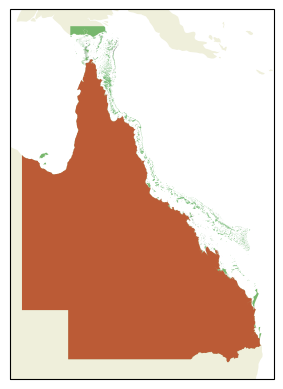

In [17]:
#Initiliasing the figure
fig = plt.figure()

#Adding a plot to the figure and assigning projection
ax = plt.axes(projection = ccrs.PlateCarree())

#Plotting all sites in green
sites.plot(ax = ax, alpha = 0.5, color = 'green')

#Plotting mainland in red
sites[sites.LOC_NAME_S.str.contains('Mainland')].plot(ax = ax, color = 'red', alpha = 0.5)

#Adding a basemap of land areas
ax.add_feature(cf.LAND)

## Saving GBR features as shapefile
We will need to provide a path to the folder where we want to save our shapefile containing the limits of all features within the GBR Marine Protected Area.

In [19]:
# Checking if Outputs folder exists, if not, creates it
os.makedirs('Outputs', exist_ok = True)

#Save output
sites.to_file('Outputs/GBR_features.shp')

That is the end of this notebook. We have demonstrated how to extract data from the Complete GBR Features dataset, how to plot it and save it locally.  